In [1]:
!pip install requests tqdm opencv-contrib-python matplotlib numpy --quiet

In [2]:
import os
import requests
import tarfile
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset Download and Extraction

In [3]:
def download_file(url, local_filename):
    """Download a file from a URL with a progress bar."""
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KB
    with open(local_filename, 'wb') as file, tqdm(
        desc=f"Downloading {local_filename}",
        total=total_size // block_size,
        unit='KB'
    ) as pbar:
        for data in response.iter_content(block_size):
            file.write(data)
            pbar.update(1)
    return local_filename

def extract_tgz(archive_path, extract_path='.'):
    """Extract a .tgz (tar.gz) archive."""
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path=extract_path)
    print(f"Extraction complete. Files extracted to: {os.path.abspath(extract_path)}")

def prepare_dataset():
    """
    Download and extract the Oxford Buildings dataset.
    The dataset (oxbuild_images.tgz) is about 1.4GB and contains JPEG images.
    """
    dataset_url = "http://www.robots.ox.ac.uk/~vgg/data/oxbuildings/oxbuild_images.tgz"
    archive_name = "oxbuild_images.tgz"
    extract_folder = "oxbuild_images"
    
    if not os.path.exists(archive_name):
        print("Downloading Oxford Buildings dataset...")
        download_file(dataset_url, archive_name)
    else:
        print(f"{archive_name} already exists.")
    
    if not os.path.exists(extract_folder):
        print("Extracting the dataset...")
        extract_tgz(archive_name, extract_path=extract_folder)
    else:
        print(f"Dataset folder '{extract_folder}' already exists.")
    return extract_folder


# Feature Detection and Matching Functions

In [4]:
def detect_and_compute(method, image):
    """
    Detect keypoints and compute descriptors using the specified method.
    Supported methods: SIFT, ORB, AKAZE, BRISK, KAZE.
    """
    if method == "SIFT":
        detector = cv2.SIFT_create()
    elif method == "ORB":
        detector = cv2.ORB_create(nfeatures=1000)
    elif method == "AKAZE":
        detector = cv2.AKAZE_create()
    elif method == "BRISK":
        detector = cv2.BRISK_create()
    elif method == "KAZE":
        detector = cv2.KAZE_create()
    else:
        raise ValueError("Unknown method: " + method)
    keypoints, descriptors = detector.detectAndCompute(image, None)
    return keypoints, descriptors

def match_features(method, desc1, desc2, matcher_type="BF"):
    """
    Match descriptors using either:
      - 'BF': Brute-Force matching with crossCheck, or
      - 'FLANN': FLANN-based matching with Lowe's ratio test.
    Returns an empty list if descriptors are None or empty.
    For binary descriptors (ORB, AKAZE, BRISK) in the FLANN branch, they are converted to float32.
    """
    if desc1 is None or desc2 is None or desc1.size == 0 or desc2.size == 0:
        return []
    
    if matcher_type == "BF":
        if method in ["SIFT", "KAZE"]:
            norm = cv2.NORM_L2
        elif method in ["ORB", "AKAZE", "BRISK"]:
            norm = cv2.NORM_HAMMING
        matcher = cv2.BFMatcher(norm, crossCheck=True)
        matches = matcher.match(desc1, desc2)
        return sorted(matches, key=lambda x: x.distance)
    
    elif matcher_type == "FLANN":
        try:
            if method in ["ORB", "AKAZE", "BRISK"]:
                desc1 = np.float32(desc1)
                desc2 = np.float32(desc2)
                index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)
            elif method in ["SIFT", "KAZE"]:
                index_params = dict(algorithm=1, trees=5)  # KDTree
            search_params = dict(checks=50)
            matcher = cv2.FlannBasedMatcher(index_params, search_params)
            raw_matches = matcher.knnMatch(desc1, desc2, k=2)
            good_matches = []
            for pair in raw_matches:
                if len(pair) == 2:
                    m, n = pair
                    if m.distance < 0.75 * n.distance:
                        good_matches.append(m)
            return sorted(good_matches, key=lambda x: x.distance)
        except cv2.error as e:
            if VERBOSE:
                print(f"FLANN matching failed for {method} due to error: {e}")
            return []
    else:
        raise ValueError("Unknown matcher type: " + matcher_type)

def compute_homography(kp1, kp2, matches):
    """Compute homography matrix using RANSAC from matched keypoints."""
    if len(matches) < 4:
        return None, None
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
    return H, mask

def reprojection_error(H, kp1, kp2, matches, mask):
    """Calculate average reprojection error over all inlier matches."""
    if H is None or mask is None or np.sum(mask) == 0:
        return np.inf
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts1_transformed = cv2.perspectiveTransform(pts1, H)
    mask = mask.ravel().astype(bool)
    error = cv2.norm(pts2[mask], pts1_transformed[mask], cv2.NORM_L2)
    return error / np.sum(mask)

def draw_matches(image1, kp1, image2, kp2, matches, mask):
    """Visualize matches between two images, showing inliers in green."""
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = None,
                       matchesMask = mask.ravel().tolist() if mask is not None else None,
                       flags = 2)
    return cv2.drawMatches(image1, kp1, image2, kp2, matches, None, **draw_params)

# Processing Multiple Image Pairs

In [5]:
def get_prefix(filename):
    """
    Extract prefix from a filename.
    Here, we define the prefix as the concatenation of the first two underscore-separated parts.
    For example, "all_souls_000000.jpg" returns "all_souls".
    """
    basename = os.path.basename(filename)
    parts = basename.split("_")
    if len(parts) >= 2:
        return "_".join(parts[:2])
    elif parts:
        return parts[0]
    return ""

def process_image_pairs(dataset_folder, detectors=["SIFT", "ORB", "AKAZE", "BRISK", "KAZE"], matcher_types=["BF", "FLANN"], target_prefix="all_souls"):
    """
    Process multiple consecutive image pairs from the dataset folder.
    Only process pairs if they have the target prefix.
    Uses tqdm to display progress.
    Returns a nested dictionary with aggregated results.
    """
    # Filter images: only include those with the target prefix.
    all_images = sorted(glob.glob(os.path.join(dataset_folder, "*.jpg")))
    image_files = [img for img in all_images if get_prefix(img) == target_prefix]
    
    if len(image_files) < 2:
        print("Not enough images with prefix", target_prefix, "in the dataset.")
        return

    overall_results = {method: {mt: {"total_error": 0, "pair_count": 0, "total_matches": 0}
                                for mt in matcher_types}
                       for method in detectors}

    for i in tqdm(range(len(image_files) - 1), desc="Processing image pairs", leave=True):
        img1 = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(image_files[i+1], cv2.IMREAD_GRAYSCALE)
        if img1 is None or img2 is None:
            continue
        for method in detectors:
            kp1, desc1 = detect_and_compute(method, img1)
            kp2, desc2 = detect_and_compute(method, img2)
            for mt in matcher_types:
                matches = match_features(method, desc1, desc2, matcher_type=mt)
                H, mask = compute_homography(kp1, kp2, matches)
                error = reprojection_error(H, kp1, kp2, matches, mask)
                num_matches = len(matches)
                if error < np.inf:
                    overall_results[method][mt]["total_error"] += error
                    overall_results[method][mt]["pair_count"] += 1
                    overall_results[method][mt]["total_matches"] += num_matches
    # Print summary
    print("\n=== Summary ===")
    for method in detectors:
        for mt in matcher_types:
            count = overall_results[method][mt]["pair_count"]
            if count > 0:
                avg_error = overall_results[method][mt]["total_error"] / count
                avg_matches = overall_results[method][mt]["total_matches"] / count
                print(f"{method} with {mt}: {count} pairs, avg error = {avg_error:.2f} pixels, avg matches = {avg_matches:.1f}")
            else:
                print(f"{method} with {mt}: No valid pairs processed")
    
    return overall_results

# visualization 

In [6]:
def plot_results(overall_results, detectors=["SIFT", "ORB", "AKAZE", "BRISK", "KAZE"], matcher_types=["BF", "FLANN"]):
    """
    Plot aggregated average reprojection errors and average number of matches.
    """
    avg_errors = {}
    avg_matches = {}
    for method in detectors:
        avg_errors[method] = {}
        avg_matches[method] = {}
        for mt in matcher_types:
            count = overall_results[method][mt]["pair_count"]
            if count > 0:
                avg_errors[method][mt] = overall_results[method][mt]["total_error"] / count
                avg_matches[method][mt] = overall_results[method][mt]["total_matches"] / count
            else:
                avg_errors[method][mt] = 0
                avg_matches[method][mt] = 0

    x = np.arange(len(detectors))
    width = 0.35

    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    
    errors_bf = [avg_errors[method]["BF"] for method in detectors]
    errors_flann = [avg_errors[method]["FLANN"] for method in detectors]
    ax[0].bar(x - width/2, errors_bf, width, label='BF')
    ax[0].bar(x + width/2, errors_flann, width, label='FLANN')
    ax[0].set_ylabel('Average Reprojection Error (pixels)')
    ax[0].set_title('Average Reprojection Error by Detector & Matcher')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(detectors)
    ax[0].legend()

    matches_bf = [avg_matches[method]["BF"] for method in detectors]
    matches_flann = [avg_matches[method]["FLANN"] for method in detectors]
    ax[1].bar(x - width/2, matches_bf, width, label='BF')
    ax[1].bar(x + width/2, matches_flann, width, label='FLANN')
    ax[1].set_ylabel('Average Number of Matches')
    ax[1].set_title('Average Number of Matches by Detector & Matcher')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(detectors)
    ax[1].legend()

    plt.tight_layout()
    plt.show()


# Main

oxbuild_images.tgz already exists.
Dataset folder 'oxbuild_images' already exists.


Processing image pairs: 100%|██████████| 131/131 [04:41<00:00,  2.15s/it]



=== Summary ===
SIFT with BF: 131 pairs, avg error = 8.03 pixels, avg matches = 882.4
SIFT with FLANN: 131 pairs, avg error = 27.32 pixels, avg matches = 66.7
ORB with BF: 131 pairs, avg error = 14.75 pixels, avg matches = 248.2
ORB with FLANN: No valid pairs processed
AKAZE with BF: 131 pairs, avg error = 3.61 pixels, avg matches = 669.4
AKAZE with FLANN: No valid pairs processed
BRISK with BF: 131 pairs, avg error = 6.64 pixels, avg matches = 1646.4
BRISK with FLANN: No valid pairs processed
KAZE with BF: 131 pairs, avg error = 2.77 pixels, avg matches = 585.2
KAZE with FLANN: 125 pairs, avg error = 3.95 pixels, avg matches = 38.6


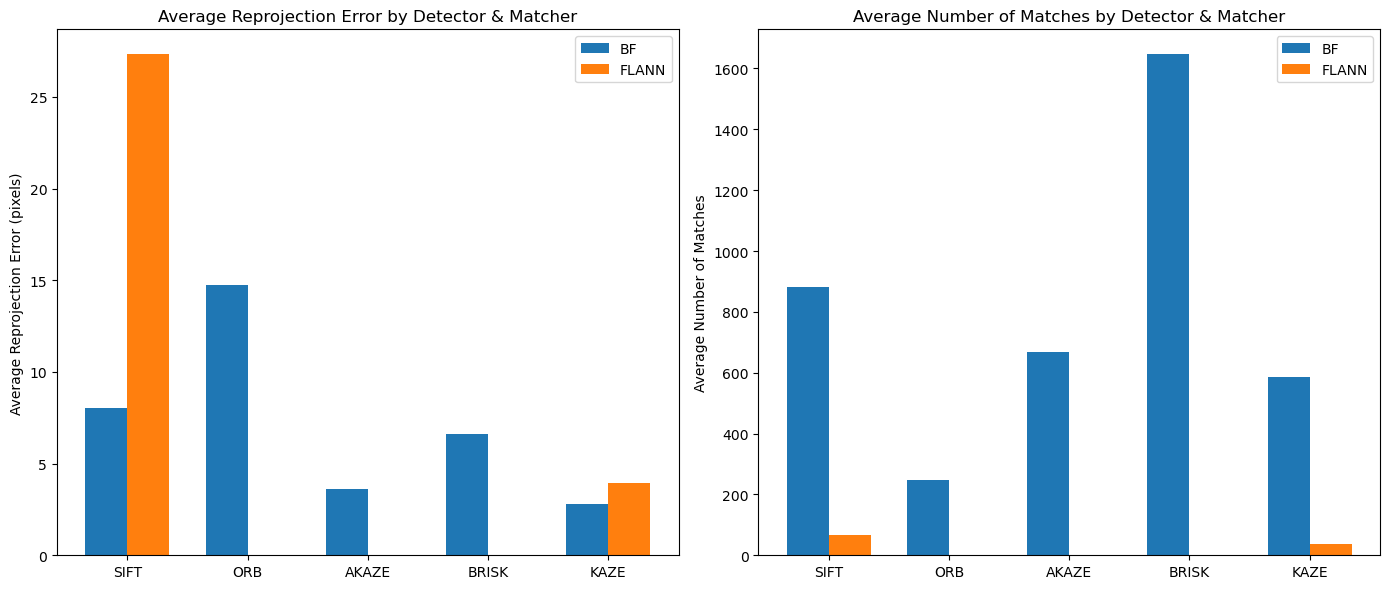

In [7]:
VERBOSE = False
# Step 1: Download and extract the Oxford Buildings dataset.
dataset_folder = prepare_dataset()  # Returns "oxbuild_images"

# Step 2: Process only images with prefix "all_souls" from the dataset.
overall_results = process_image_pairs(dataset_folder, target_prefix="all_souls")

# Step 3: Plot the aggregated results.
plot_results(overall_results)

## show some of the matching points

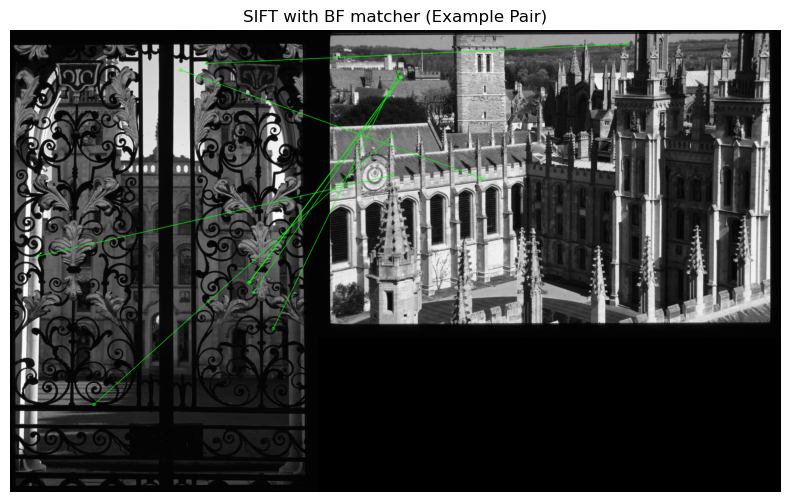

In [8]:
image_files = sorted(glob.glob(os.path.join(dataset_folder, "*.jpg")))
filtered_files = [f for f in image_files if get_prefix(f) == "all_souls"]
for i in range(len(filtered_files) - 1):
    img1 = cv2.imread(filtered_files[i], cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(filtered_files[i+1], cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None:
        continue
    method = "SIFT"
    matcher_type = "BF"
    kp1, desc1 = detect_and_compute(method, img1)
    kp2, desc2 = detect_and_compute(method, img2)
    matches = match_features(method, desc1, desc2, matcher_type=matcher_type)
    H, mask = compute_homography(kp1, kp2, matches)
    matched_img = draw_matches(img1, kp1, img2, kp2, matches, mask)
    plt.figure(figsize=(12, 6))
    plt.title(f"{method} with {matcher_type} matcher (Example Pair)")
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    break